In [1]:
!pip install matplotlib_venn gensim matplotlib pandas numpy tqdm

In [2]:
from collections import Counter
from functools import reduce
import os


from matplotlib_venn import venn2_unweighted
from gensim.utils import deaccent
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

tqdm.pandas()


In [3]:
datasets = dict()

In [4]:
RAW_DATA_DIR = "raw_data"

In [5]:
%cd {RAW_DATA_DIR}

/mnt/d/Pesquisa/Fact br eval/raw_data


## A - Baixar dados

In [6]:
#!wget https://github.com/kamplus/FakeNewsSet/raw/master/Dataset/News_fake.csv
#!wget https://github.com/kamplus/FakeNewsSet/raw/master/Dataset/News_notFake.csv
#!wget https://zenodo.org/record/5191798/files/central_de_fatos.csv
#!wget https://github.com/Gabriel-Lino-Garcia/FakeRecogna/raw/master/dataset/FakeRecogna.xlsx
#!git clone https://github.com/roneysco/Fake.br-Corpus
#!gdown --id 1Xx_4bw37cgrEkEhQ1toLsIbAj2pLgvDx -O fact-check_tweet_dataset.zip
#!unzip fact-check_tweet_dataset.zip

## B - Importar dados

In [7]:
datasets["Central de fatos"] = pd.read_csv("central_de_fatos.csv", sep=";")
print(datasets["Central de fatos"].shape[0])
datasets["Central de fatos"]["rating"] = datasets["Central de fatos"]["rating"].str.lower().apply(eval).apply(set)
datasets["Central de fatos"] = datasets["Central de fatos"][datasets["Central de fatos"]["rating"].apply(len) == 1]
print(datasets["Central de fatos"].shape[0])
datasets["Central de fatos"]["categories"] = datasets["Central de fatos"]["categories"] \
    .apply(lambda c: eval(c) if isinstance(c, str) and "[" in c else c) \
    .apply(lambda c: c[0] if isinstance(c, list) and len(c) > 0 else c) \
    .apply(lambda c: "" if isinstance(c, list) and len(c) == 0 else c)

11647
10551


In [8]:
fake_news_set_fake = pd.read_csv("News_fake.csv")
fake_news_set_fake["alternative_name"] = "fake"

fake_news_set_not_fake = pd.read_csv("News_notFake.csv")
fake_news_set_not_fake["alternative_name"] = "not_fake"

fake_news_set = pd.concat([fake_news_set_fake, fake_news_set_not_fake])
datasets["FakeNewsSet"] = fake_news_set
datasets["FakeNewsSet"]["tweet_ids"] = datasets["FakeNewsSet"]["tweet_ids"].str.split("\t")

In [9]:
print(datasets["FakeNewsSet"].shape[0])
print(datasets["FakeNewsSet"]["tweet_ids"].apply(len).sum())

600
27059


In [10]:
columns = [
 "author",
 "link",
 "category",
 "date of publication",
 "number of tokens",
 "number of words without punctuation",
 "number of types",
 "number of links inside the news",
 "number of words in upper case",
 "number of verbs",
 "number of subjuntive and imperative verbs",
 "number of nouns",
 "number of adjectives",
 "number of adverbs",
 "number of modal verbs (mainly auxiliary verbs)",
 "number of singular first and second personal pronouns",
 "number of plural first personal pronouns",
 "number of pronouns",
 "pausality",
 "number of characters",
 "average sentence length",
 "average word length",
 "percentage of news with speeling errors",
 "emotiveness",
 "diversity",
]

raw_data = list()


for label in ["fake", "true"]:
    text_dir = os.path.join("Fake.br-Corpus", "full_texts", label)
    metadata_dir = os.path.join("Fake.br-Corpus", "full_texts", f"{label}-meta-information")
    crop_dir = os.path.join("Fake.br-Corpus", "size_normalized_texts", label)

    for example in tqdm(os.listdir(text_dir)):
        text_path = os.path.join(text_dir, example)
        metadata_path = os.path.join(metadata_dir, example.replace(".txt","-meta.txt"))
        crop_path = os.path.join(crop_dir, example)
    
        with open(text_path, "r") as f:
            text = f.read()

        cropped_text = np.nan
        if os.path.exists(crop_path):
            with open(crop_path, "r") as f:
                cropped_text = f.read()

        with open(metadata_path, "r") as f:
            metadata = f.read().split("\n")

        example_data =  dict(zip(columns, metadata))
        example_data["text"] = text
        example_data["size_normalized_text"] = cropped_text
        example_data["label"] = label

        raw_data.append(example_data)

raw_data = pd.DataFrame(raw_data)
prepro_data = pd.read_csv(os.path.join("Fake.br-Corpus", "preprocessed", "pre-processed.csv"), index_col="index")
raw_data["preprocessed_news"] = prepro_data["preprocessed_news"]
datasets["Fake.br"] = raw_data

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [11]:
datasets["Fact-check_tweet"] = pd.read_csv("pt_pt.csv")
print(datasets["Fact-check_tweet"].shape[0])
datasets["Fact-check_tweet"] = datasets["Fact-check_tweet"][~datasets["Fact-check_tweet"]["article_url"].str.startswith("https://factly.in")]
datasets["Fact-check_tweet"] = datasets["Fact-check_tweet"].reset_index()
print(datasets["Fact-check_tweet"].shape[0])

804
803


In [12]:
datasets["FakeRecogna"] = pd.read_excel("FakeRecogna.xlsx")
print(datasets["FakeRecogna"].shape[0])
datasets["FakeRecogna"] = datasets["FakeRecogna"][datasets["FakeRecogna"]["URL"].notna()]
print(datasets["FakeRecogna"].shape[0])

11903
11902


## C - Selecionar datasets

Selecionei somente os datasets que possuem uma url atrelada a alegação e/ou a fonte

In [13]:
claim_datasets = {
    "Fake.br": 'link',

    # ambos são de tweets
    "Fact-check_tweet": 'tweet_id',
    "FakeNewsSet": "tweet_ids",
}


review_datasets = {
    "FakeRecogna": 'URL',
    "Central de fatos": 'url',
    "Fact-check_tweet": 'article_url',
    "FakeNewsSet": 'news_url',
}

## D - Unificar

In [14]:
def norm_domain(domain):
    for suffix in ["gazetadigital.com.br", "tnh1.com.br", "folhavitoria.com.br", "jornaldebrasilia.com.br"]:
        if domain in suffix:
            return "r7.com"

    for suffix in ["globo.com", "uol.com.br", "estadao.com.br", "sapo.pt", "afp.com", "r7.com"]:
        if suffix in domain:
            return suffix

    return domain

treat_url = lambda url: "//".join(url.split("//")[1:]).replace("www.","")
find_domain = lambda url: norm_domain(treat_url(url).split("/")[0])

In [15]:
raw_df = datasets["FakeRecogna"]

fakeRecogna = pd.DataFrame()

fakeRecogna["review_text"] = raw_df["Titulo"] + "\n" + raw_df["Subtitulo"].fillna("") + "\n" + raw_df["Noticia"]
fakeRecogna["review_text"] = fakeRecogna["review_text"].str.strip()

fakeRecogna["review_author"] = raw_df["Autor"].fillna("").str.strip()
fakeRecogna["review_author"] = fakeRecogna["review_author"].apply(lambda a: a if "/20" not in a else "")
fakeRecogna["review_author"] = fakeRecogna["review_author"].fillna("").str.replace("Por ", "")
fakeRecogna["review_author"] = fakeRecogna["review_author"].apply(lambda a: a if len(a.split(" ")) <= 22 else "")

fakeRecogna["review_url"] = raw_df["URL"].fillna("").str.strip()
fakeRecogna["review_domain"] = fakeRecogna["review_url"].apply(find_domain)

fakeRecogna["review_date"] = raw_df["Data"].fillna("").str.strip()
fakeRecogna["review_date"] = fakeRecogna["review_date"].apply(lambda d: d if isinstance(d, str) and len(d) >= 10 else "")
fakeRecogna["review_date"] = fakeRecogna["review_date"].apply(lambda d: d[:10] if isinstance(d, str) and len(d) > 10 else d)
fakeRecogna["review_date"] = fakeRecogna["review_date"].fillna("").str.strip()

fakeRecogna["category"] = raw_df["Categoria"]
fakeRecogna["is_fake"] = raw_df["Classe"].map({0.0: 1, 1.0: -1})

In [16]:
FAKE_LABELS = {"boato", "falso", "fake", "enganoso", "fora de contexto", "distorcido", "exagerado", "constraditório", "impreciso", "insustentável", "contexto errado"}

def map_rating(rating: set):
    if rating.intersection(FAKE_LABELS):
        return 1
    elif rating.intersection({"verdadeiro, mas", "ainda é cedo para dizer"}):
        return 0
    
    return -1

raw_df = datasets['Central de fatos']


central_de_fatos = pd.DataFrame()

central_de_fatos["review_text"] = raw_df["title"] + "\n" + raw_df["subtitle"].fillna("") + "\n" + raw_df["text_news"]
central_de_fatos["review_text"] = central_de_fatos["review_text"].str.strip()

central_de_fatos["review_author"] = ""
central_de_fatos["review_url"] = raw_df["url"].str.strip()
central_de_fatos["review_domain"] = central_de_fatos["review_url"].apply(find_domain)
central_de_fatos["review_date"] = raw_df["publication_date"].fillna("").str.strip()
central_de_fatos["category"] = raw_df["categories"].str.lower()
central_de_fatos["is_fake"] = raw_df["rating"].map(map_rating)

In [17]:
fact_check_tt_pt = pd.DataFrame()
raw_df = datasets['Fact-check_tweet']
fact_check_tt_pt["review_url"] = raw_df["article_url"]
fact_check_tt_pt["review_domain"] = fact_check_tt_pt["review_url"].apply(find_domain)
fact_check_tt_pt["claim_ids"] = raw_df["tweet_id"].apply(lambda x: [x])
fact_check_tt_pt["is_fake"] = raw_df["label"].map({0: -1, 1:1})

In [18]:
fakeNewsSet = pd.DataFrame()
raw_df = datasets["FakeNewsSet"]
fakeNewsSet["review_url"] = raw_df["news_url"]
fakeNewsSet["review_domain"] = fakeNewsSet["review_url"].apply(find_domain)
fakeNewsSet["claim_ids"] = raw_df["tweet_ids"]
fakeNewsSet["is_fake"] = raw_df["alternative_name"].map({"fake": 1, "not_fake":-1})

In [19]:
fakebr = pd.DataFrame()
raw_df = datasets['Fake.br']
fakebr["claim_text"] = raw_df["text"]
fakebr["claim_author"] = raw_df["author"]
fakebr["claim_url"] = raw_df["link"]
fakebr["claim_date"] = raw_df["date of publication"]
fakebr["category"] = raw_df["category"]
fakebr["is_fake"] = raw_df["label"].map({"fake":  1, "true": -1})

In [20]:
final_dataset = {
    "fact_check_tweet_pt": fact_check_tt_pt,
    "FakeNewsSet": fakeNewsSet,
    "FakeRecogna": fakeRecogna,
    "central_de_fatos": central_de_fatos,
    "fakebr": fakebr,
}

In [21]:
review_urls = {dataset: set(final_dataset[dataset]["review_url"]) for dataset  in final_dataset if dataset != "fakebr"}
review_urls = {d: {treat_url(url) for url in urls} for d, urls in review_urls.items()}

all_review_urls = reduce(lambda a, b: a.union(b), review_urls.values())

review_urls_count = list()
for review_url in all_review_urls:
    item = {"review_url": review_url}
    item.update({dataset: review_url in review_urls[dataset] for dataset in review_urls.keys()})
    review_urls_count.append(item)

review_urls_count = pd.DataFrame(review_urls_count).set_index("review_url")

In [22]:
len(all_review_urls)

20028

In [23]:
url_idx = pd.DataFrame(review_urls_count.index).reset_index()
url_idx["index"] = url_idx["index"].apply(lambda idx: f"review_{idx:05d}")
url_idx = url_idx.set_index("review_url")["index"].to_dict()

In [24]:
review_id = fakeRecogna["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fakeRecogna.insert(0, "review_id", review_id)

review_id = central_de_fatos["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
central_de_fatos.insert(0, "review_id", review_id)

review_id = fact_check_tt_pt["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fact_check_tt_pt.insert(0, "review_id", review_id)

review_id = fakeNewsSet["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fakeNewsSet.insert(0, "review_id", review_id)

In [25]:
review_urls_count.columns = ["FakeRecogna", "central_de_fatos", "fact_check_tweet_pt", 'FakeNewsSet']

In [26]:
diff_reviews = set()

intersection_urls = review_urls_count[review_urls_count.sum(axis=1) > 1]
for url, row in tqdm(intersection_urls.iterrows(), total=intersection_urls.shape[0]):
    intersection_label = set()

    review_id = url_idx[url]
    for dataset in row[row == True].index:
        dataset_label = final_dataset[dataset][final_dataset[dataset]["review_id"] == review_id]["is_fake"]
        if not dataset_label.any():
            continue
        
        dataset_label = dataset_label.iloc[0] 
        intersection_label.add(dataset_label)

    if len(intersection_label) > 1:
        diff_reviews.add(review_id)
    

  0%|          | 0/3303 [00:00<?, ?it/s]

In [27]:
for dataset in final_dataset:
    if not "review_id" in final_dataset[dataset].columns:
        continue

    final_dataset[dataset] = final_dataset[dataset][~final_dataset[dataset]["review_id"].isin(diff_reviews)]

In [28]:
%cd ..
os.makedirs("data", exist_ok=True)

/mnt/d/Pesquisa/Fact br eval


In [29]:
for dataset in final_dataset:
    final_dataset[dataset].to_csv(os.path.join("data",f"{dataset}.tsv"), sep="\t", index=None)

In [106]:
!zip -r FactChecksbr.zip data

updating: data/ (stored 0%)
updating: data/central_de_fatos.tsv (deflated 68%)
updating: data/fact_check_tweet_pt.tsv (deflated 75%)
updating: data/FakeNewsSet.tsv (deflated 61%)
updating: data/FakeRecogna.tsv (deflated 65%)
updating: data/fakebr.tsv (deflated 63%)


## E - Análises iniciais

In [30]:
pretty_name = {
    "fact_check_tweet_pt": "Fact-check_tweet (pt)",
    "FakeNewsSet": "FakeNewsSet",
    "FakeRecogna": "FakeRecogna",
    "central_de_fatos": "Central de fatos",
    "fakebr": "Fake.br",
}

In [104]:
for dataset in final_dataset:
    name = pretty_name[dataset]
    n_reviews = 0
    n_claims = 0

    if dataset != "fakebr":
        n_reviews = final_dataset[dataset].shape[0]
    else:
        n_claims = final_dataset[dataset].shape[0]
    
    if dataset in ["FakeNewsSet", "fact_check_tweet_pt"]:
        n_claims = final_dataset[dataset]["claim_ids"].apply(len).sum()

    print(name, n_claims, n_reviews)


Fact-check_tweet (pt) 656 656
FakeNewsSet 26970 598
FakeRecogna 0 11773
Central de fatos 0 10461
Fake.br 7200 0


In [78]:
domain_count = pd.DataFrame()
for dataset in final_dataset:
    if dataset == "fakebr":
        continue

    count = final_dataset[dataset].value_counts("review_domain").reset_index(name=pretty_name[dataset])
    
    if domain_count.shape[0] == 0:
        domain_count = count
    else:
        domain_count = domain_count.merge(count, on="review_domain", how="outer")

domain_count = domain_count.fillna(0).set_index("review_domain").astype(int)
domain_count = domain_count.loc[(domain_count > 0).sum(axis=1).sort_values(ascending=False).index]
domain_count = domain_count.loc[(domain_count > 0).sum(axis=1).sort_values(ascending=False).index]
domain_count = domain_count.loc[domain_count.index[:-6].to_list() + ["e-farsas.com", "gov.br", "sapo.pt", "observador.pt", "r7.com", "ricmais.com.br"]]
domain_count = domain_count[["FakeRecogna", "Central de fatos", "Fact-check_tweet (pt)", "FakeNewsSet"]]

In [89]:
domain_count

,FakeRecogna,Central de fatos,Fact-check_tweet (pt),FakeNewsSet
review_domain,,,,
uol.com.br,4987,1824,214,143
globo.com,2451,785,27,279
aosfatos.org,0,1430,135,142
afp.com,503,0,60,10
boatos.org,2425,5468,45,0
projetocomprova.com.br,388,361,2,0
estadao.com.br,0,593,70,0
apublica.org,0,0,4,11
e-farsas.com,804,0,0,0


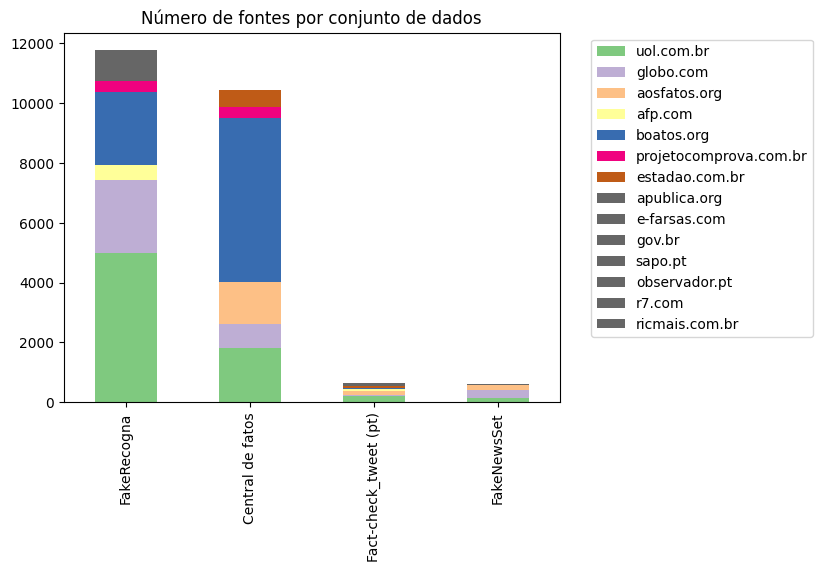

In [95]:
ax = domain_count.T.plot(kind='bar', stacked=True, color=[plt.cm.Accent(i) for i in range(15)], title="Número de fontes por conjunto de dados")
_ = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

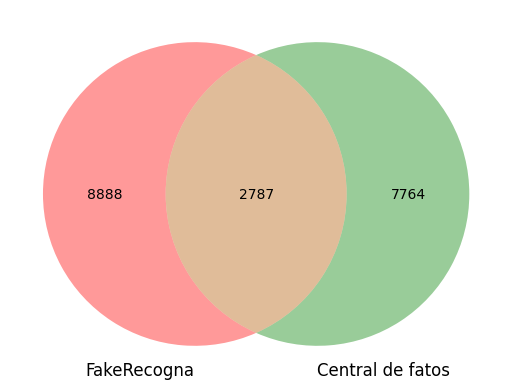

In [34]:
_ = venn2_unweighted([review_urls["FakeRecogna"], review_urls["central_de_fatos"]], set_labels=[pretty_name["FakeRecogna"], pretty_name["central_de_fatos"]])

In [35]:
categories_1  = final_dataset["FakeRecogna"].value_counts(subset="category").reset_index(name="FakeRecogna")
categories_1["category"] = categories_1["category"].str.lower()

categories_2 = final_dataset["central_de_fatos"].value_counts(subset="category").reset_index(name="Central de fatos")
categories_2["category"] = categories_2["category"].str.lower()

In [56]:
categories_1.merge(categories_2, on="category")

,category,FakeRecogna,Central de fatos
0,entretenimento,1383,460
1,brasil,890,1076
2,mundo,558,546


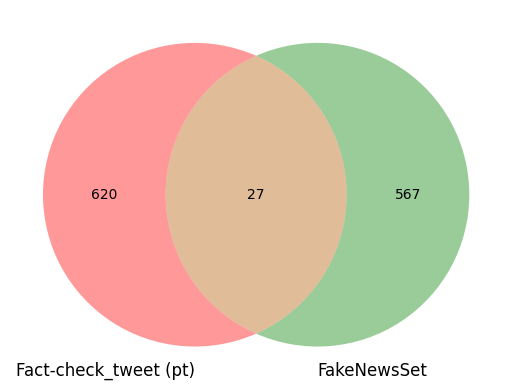

In [37]:
_ = venn2_unweighted([review_urls['fact_check_tweet_pt'], review_urls["FakeNewsSet"]], set_labels=[pretty_name['fact_check_tweet_pt'], "FakeNewsSet"])

In [38]:
domain_count.sum().sum()

23488

In [39]:
print(intersection_urls.shape[0], len(diff_reviews))

3303 130


In [40]:
review_urls_count.value_counts().reset_index().loc[[0,1,6,3]]

,FakeRecogna,central_de_fatos,fact_check_tweet_pt,FakeNewsSet,0
0,False,False,True,False,8841
1,False,False,False,True,7298
6,True,False,False,True,192
3,False,True,False,False,312


In [41]:
review_urls_count.value_counts().reset_index().loc[[2,8,10,5,4,11]]

,FakeRecogna,central_de_fatos,fact_check_tweet_pt,FakeNewsSet,0
2,False,False,True,True,2675
8,True,False,True,False,42
10,False,True,True,False,5
5,False,True,False,True,250
4,True,False,False,False,274
11,True,True,False,False,3


In [42]:
review_urls_count.value_counts().reset_index().loc[[7,9]]

,FakeRecogna,central_de_fatos,fact_check_tweet_pt,FakeNewsSet,0
7,True,False,True,True,112
9,True,True,False,True,24


In [43]:
review_count = review_urls_count.sum(axis=1).sort_values(ascending=False).reset_index()

In [44]:
review_count[0].value_counts()

1    16725
2     3167
3      136
Name: 0, dtype: int64

In [45]:
tweet_ids = dict()
tweet_ids['Fact-check_tweet (pt)'] = set(final_dataset['fact_check_tweet_pt']['claim_ids'].apply(lambda item: item[0]))
tweet_ids["FakeNewsSet"] = reduce(lambda a, b: set(a).union(set(b)),final_dataset["FakeNewsSet"]['claim_ids'])

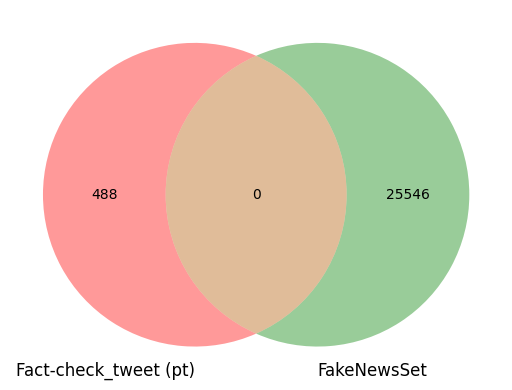

In [46]:
_ = venn2_unweighted([tweet_ids['Fact-check_tweet (pt)'], tweet_ids["FakeNewsSet"]], set_labels=['Fact-check_tweet (pt)', "FakeNewsSet"])

In [47]:
categories_1_fixed = final_dataset["FakeRecogna"]["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","").split("/")[1])
categories_1_fixed = categories_1_fixed[categories_1_fixed.str.len() < 30].dropna().value_counts().reset_index(name="FakeRecogna").rename(columns={"index": "category"})
categories_2["category"] = categories_2["category"].apply(deaccent)

In [61]:
categories_2.merge(categories_1_fixed,on="category")

,category,Central de fatos,FakeRecogna
0,,2417,503
1,politica,1545,1523
2,brasil,1076,336
3,saude,652,1303
4,tecnologia,549,295
5,mundo,546,385
6,entretenimento,460,163
7,religiao,267,97
8,esporte,215,276
9,ciencia,78,38


In [49]:
label_count = pd.DataFrame()
for dataset in final_dataset:
    count = final_dataset[dataset].value_counts("is_fake").reset_index(name=pretty_name[dataset])
    
    if label_count.shape[0] == 0:
        label_count = count
    else:
        label_count = label_count.merge(count, on="is_fake", how="outer")

label_count = label_count.sort_values("is_fake").set_index("is_fake").fillna(0).astype(int)

<Axes: title={'center': 'Balanceamento dos conjuntos de dados processados'}>

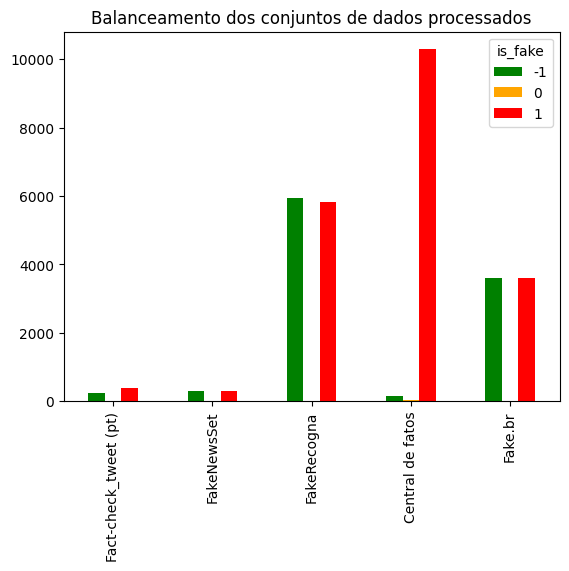

In [105]:
label_count.T.plot(kind="bar", color=["green", "orange", "red"], title="Balanceamento dos conjuntos de dados processados")